In [1]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [ ]:
class CFG:  
    # path defination
    class Path:
        train_df = '/kaggle/input/eurosat-dataset/EuroSAT/train.csv'
        val_df = '/kaggle/input/eurosat-dataset/EuroSAT/validation.csv'
        test_df = '/kaggle/input/eurosat-dataset/EuroSAT/test.csv'
        image_folder = '/kaggle/input/eurosat-dataset/EuroSAT'
        model_save_path = '/kaggle/working/weights/'
        tensorboard_logs_path = "/kaggle/working/tensorboard/logs/"
        figure_save_path = "/kaggle/working/Figures/"
        
    # dataset parameter
    class Dataset:
        batch_size = 64
        img_size = (64, 64)
        buffer_size = 1000
    
    class HyperParameter:
        batch_size = 64
        learning_rate = 0.0001
        input_shape = (64, 64, 3)
        num_classes = 10
        epochs = 100

In [ ]:
class EuroSatLoader:
    def __init__(self, csv_path, image_folder, batch_size = 32, img_size = (32, 32), buffer_size = 100, shuffle = True):
        self.csv_path = csv_path
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.buffer_size = buffer_size
        
        # Load the CSV files using pandas
        self.df = pd.read_csv(self.csv_path)
        # Create a list of image paths and labels for train, validation, and test datasets
        self.image_paths = [os.path.join(self.image_folder, filename) for filename in self.df.Filename] 
        self.labels = self.df.Label.values
        
    def load_image(self, image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3) #
        image = tf.image.resize(image, self.img_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    
    def get_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_paths, self.labels))
        dataset = dataset.map(self.load_image, num_parallel_calls=tf.data.AUTOTUNE)
        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=self.buffer_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size=self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

Base Model Creation

In [11]:
class BaselineCNN:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
    
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(inputs)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)
        x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)
        x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)
        x = tf.keras.layers.Dropout(0.3) (x)
        x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)
        x = tf.keras.layers.Dropout(0.3) (x)
        x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)
        x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        return model
    
    def compile(self, learning_rate):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self, train_data, val_data, epochs, batch_size, model_save_path, log_dir):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path + 'best_model.h5', monitor='val_loss', mode='min', save_weights_only=True,save_best_only=True, verbose=1)
        tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
        callbacks = [early_stop, checkpoint, tensorboard]
        history = self.model.fit(train_data, 
                                 epochs=epochs,
                                 batch_size=batch_size, 
                                 validation_data=val_data, 
                                 callbacks=callbacks)
        return history
    def evaluate(self, data):
        loss, accuracy = self.model.evaluate(data)
        return loss, accuracy
    
    def predict(self, data):
        return self.model.predict(data)
    
    def summary(self):
        return self.model.summary()
        
    def load_model(self, model_path):
        self.model.load_weights(model_path)
        
    def plot_model_architecture(self, file_path):
        tf.keras.utilsplot_model(self, to_file=file_path, show_shapes=True)

Model Creation

In [12]:
class ModelUtils:
    
    @staticmethod
    def plot_cm(y_true, y_pred, class_names,save_path, figsize=(10,10)):
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        # cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm = pd.DataFrame(cm, index=[i for i in class_names],
                    columns = [i for i in class_names])
        
        cm.index.name = 'True label'
        cm.columns.name = 'Predicted label'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, annot=annot, fmt='', ax=ax)
        plt.savefig(save_path+'confusion_matrix.png')
        
        
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, labels):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        ax = plt.subplot()
        sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        plt.show()
        
    

    @staticmethod
    def plot_loss_accuracy(save_path,history):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(history.history['loss'], label='train')
        ax[0].plot(history.history['val_loss'], label='validation')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Loss vs Epoch')
        ax[0].legend()
        ax[1].plot(history.history['accuracy'], label='train')
        ax[1].plot(history.history['val_accuracy'], label='validation')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_title('Accuracy vs Epoch')
        ax[1].legend()
        plt.savefig(save_path+'loss_accuracy_curve.png')
        plt.show()

    # function for scoring roc auc score for multi-class
    @staticmethod
    def multiclass_roc_auc_score(y_true, model_predicted_label,class_names,save_path, average="macro"):
        fig, c_ax = plt.subplots(1,1, figsize = (16, 16))
        lb = LabelBinarizer()
        lb.fit(y_true)
        y_test = lb.transform(y_true)
        y_pred = lb.transform(model_predicted_label)
        
        for (idx, c_label) in enumerate(class_names):
            fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
            c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
        
        c_ax.legend()
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        plt.savefig(save_path+'roc_auc_curve.png')
        plt.show()
        return roc_auc_score(y_test, y_pred, average=average)

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-13 23:32:40.061472: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-13 23:32:40.061720: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-13 23:32:40.061743: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-13 23:32:40.061792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-13 23:32:40.062030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

Epoch 1/20


2024-07-13 23:32:41.685766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 85s 479ms/step - accuracy: 0.0610 - loss: 3.0479 - val_accuracy: 0.0824 - val_loss: 2.9512
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 90s 527ms/step - accuracy: 0.1036 - loss: 2.8702 - val_accuracy: 0.1448 - val_loss: 2.7159
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 95s 559ms/step - accuracy: 0.1364 - loss: 2.7327 - val_accuracy: 0.1895 - val_loss: 2.5487
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 98s 575ms/step - accuracy: 0.1924 - loss: 2.5557 - val_accuracy: 0.2310 - val_loss: 2.4333
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 96s 562ms/step - accuracy: 0.2319 - loss: 2.4344 - val_accuracy: 0.2824 - val_loss: 2.2860
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 108s 633ms/step - accuracy: 0.2725 - loss: 2.3064 - val_accuracy: 0.3367 - val_loss: 2.1175
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 108s 636ms/step - accuracy: 0.2988 - loss: 2.2036 - val_accuracy: 0.3643 - val_loss: 2.0292
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 107s 630ms/step - accuracy: 0.3201 - loss: 2.1403 - 

In [ ]:
if __name__ == '__main__':
    cfg = CFG()
    Path(cfg.Path.model_save_path).mkdir(parents = True, exist_ok = True)
    Path(cfg.Path.tensorboard_logs_path).mkdir(parents = True, exist_ok = True)
    Path(cfg.Path.figure_save_path).mkdir(parents = True, exist_ok = True)

    train_loader = EuroSatLoader(csv_path = cfg.Path.train_df, 
                                image_folder = cfg.Path.image_folder,
                                batch_size = cfg.Dataset.batch_size,
                                img_size = cfg.Dataset.img_size,
                                buffer_size = cfg.Dataset.buffer_size, 
                                shuffle = True)
    train_dataset = train_loader.get_dataset()

    # print("Train Dataset")
    # for i, (x, y) in enumerate(train_dataset):
    #     print(x.shape, y.shape)
    #     if i == 10:
    #         break

    val_loader = EuroSatLoader(csv_path = cfg.Path.val_df, 
                                image_folder = cfg.Path.image_folder,
                                batch_size = cfg.Dataset.batch_size,
                                img_size = cfg.Dataset.img_size,
                                buffer_size = cfg.Dataset.buffer_size, 
                                shuffle = False)
    val_dataset = val_loader.get_dataset()
    test_loader = EuroSatLoader(csv_path = cfg.Path.test_df, 
                                image_folder = cfg.Path.image_folder,
                                batch_size = cfg.Dataset.batch_size,
                                img_size = cfg.Dataset.img_size,
                                buffer_size = cfg.Dataset.buffer_size, 
                                shuffle = False)
    test_dataset = test_loader.get_dataset()
    
    model = BaselineCNN(input_shape = cfg.HyperParameter.input_shape, 
                        num_classes = cfg.HyperParameter.num_classes)
    
    print(f"INFO ===========Training Started===============")
    model.compile(learning_rate= cfg.HyperParameter.learning_rate)
    history = model.train(train_data = train_dataset, 
                          val_data = val_dataset,
                          epochs = cfg.HyperParameter.epochs,
                          batch_size= cfg.HyperParameter.batch_size, 
                          model_save_path= cfg.Path.model_save_path,
                          log_dir= cfg.Path.tensorboard_logs_path)
    print(f"INFO ===========Training Finished===============")
    print(f"INFO ===========Plot Curve===============")
    ModelUtils.plot_loss_accuracy(cfg.Path.figure_save_path,history)

329/329 ━━━━━━━━━━━━━━━━━━━━ 84s 255ms/step - accuracy: 0.3681 - loss: 1.9468
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.3940 - loss: 1.8551
Train accuracy: 0.3667, Test accuracy: 0.3952


NameError: name 'history' is not defined

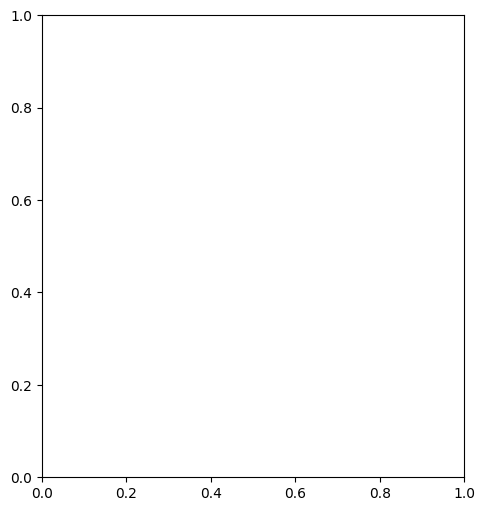

In [ ]:
    model.load_model('/kaggle/working/weights/best_model.h5')
    
    train_loss, train_acc = model.evaluate(train_dataset)
    print(f"train_loss:{train_loss}:: train_accuracy: {train_acc}")
    
    val_loss, val_acc = model.evaluate(val_dataset)
    print(f"val_loss:{val_loss}:: val_acc: {val_acc}")
    
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"test_loss:{test_loss}:: test_acc: {test_acc}")
        
    predictions = model.predict(test_dataset)
    predicted_label = np.argmax(predictions, axis = 1)

    class_names = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial",
                   "Pasture","PermanentCrop","Residential","River","SeaLake"]
    
    true_labels = []
    for image, label in test_dataset: #.as_numpy_iterator()
        true_labels += list(label.numpy())
    
    # Plot confusion Matrix
    ModelUtils.plot_cm(y_true = true_labels, y_pred = predicted_label, class_names = class_names,save_path=cfg.Path.figure_save_path)
    #Plot Roc Auc Curve
    ModelUtils.multiclass_roc_auc_score(y_true= true_labels, model_predicted_label= predicted_label,class_names = class_names,save_path=cfg.Path.figure_save_path)